
# **Machine Learning on Big DatA **
---


# **Initiate and Configure Spark**

In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# **Task 1 **
---

In [ ]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("CN7030") \
    .getOrCreate()

# Load CSV file
data_path = "/content/drive/MyDrive/machine/TMDB_movie_dataset_v11.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Preview the data
df.show(5)
df.printSchema()


+------+---------------+------------+----------+--------+------------+----------+-------+-----+--------------------+---------+--------------------+---------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    id|          title|vote_average|vote_count|  status|release_date|   revenue|runtime|adult|       backdrop_path|   budget|            homepage|  imdb_id|original_language| original_title|            overview|          popularity|         poster_path|             tagline|              genres|production_companies|production_countries|    spoken_languages|            keywords|
+------+---------------+------------+----------+--------+------------+----------+-------+-----+--------------------+---------+--------------------+---------+-----------------+---------------+--------------------+--------------------+-----

**Data Cleaning **

In [ ]:

from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Step 1: Define numeric columns you want to use
numeric_cols = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'revenue']

# Step 2: Select these columns
df_clean = df.select(*numeric_cols)

# Step 3: Cast to float and remove nulls & negative values
for col_name in numeric_cols:
    df_clean = df_clean.withColumn(col_name, col(col_name).cast(FloatType()))
    df_clean = df_clean.filter((col(col_name).isNotNull()) & (col(col_name) >= 0))

# Step 4: IQR-based outlier removal
def remove_outliers_iqr(df, col_name):
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df.filter((col(col_name) >= lower) & (col(col_name) <= upper))

for col_name in numeric_cols:
    df_clean = remove_outliers_iqr(df_clean, col_name)

# Step 5: Drop remaining nulls if any, and cache
df_cleaned = df_clean.dropna().cache()

# Preview cleaned data
df_cleaned.show(5)
df_cleaned.describe().show()


+------+----------+-------+------------+----------+-------+
|budget|popularity|runtime|vote_average|vote_count|revenue|
+------+----------+-------+------------+----------+-------+
|   0.0|       0.6|    0.0|         0.0|       0.0|    0.0|
|   0.0|       0.6|    0.0|         0.0|       0.0|    0.0|
|   0.0|       0.6|   89.0|         0.0|       0.0|    0.0|
|   0.0|       0.6|    0.0|         0.0|       0.0|    0.0|
|   0.0|       0.6|  123.0|         0.0|       0.0|    0.0|
+------+----------+-------+------------+----------+-------+
only showing top 5 rows

+-------+------+-------------------+-----------------+--------------------+----------+-------+
|summary|budget|         popularity|          runtime|        vote_average|vote_count|revenue|
+-------+------+-------------------+-----------------+--------------------+----------+-------+
|  count|572949|             572949|           572949|              572949|    572949| 572949|
|   mean|   0.0| 0.6430857353602583|32.86914193060814|7

**Pre-Processing**

In [ ]:

from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Step 1: Define numeric feature columns (same as cleaning)
feature_cols = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'revenue']

# Step 2: Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
df_vector = assembler.transform(df_cleaned)

# Step 3: Scale features to range [0, 1] using MinMaxScaler
scaler = MinMaxScaler(inputCol="raw_features", outputCol="feature")
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Show the scaled features
df_scaled.select("feature").show(5, truncate=False)


+--------------------------------------------------------+
|feature                                                 |
+--------------------------------------------------------+
|[0.5,0.3696305016360815,0.0,0.0,0.5,0.5]                |
|[0.5,0.3696305016360815,0.0,0.0,0.5,0.5]                |
|[0.5,0.3696305016360815,0.48901098901098905,0.0,0.5,0.5]|
|[0.5,0.3696305016360815,0.0,0.0,0.5,0.5]                |
|[0.5,0.3696305016360815,0.6758241758241759,0.0,0.5,0.5] |
+--------------------------------------------------------+
only showing top 5 rows



---
# **Task 2**
---


In [ ]:

# KMeans Clustering Model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Step 1: Define no.of clusters (k) and use predictionCol="prediction"
kmeans = KMeans(featuresCol="feature", predictionCol="prediction", k=5, seed=42)

# Step 2: Fit the model
kmeans_model = kmeans.fit(df_scaled)

# Step 3: Make predictions
df_kmeans = kmeans_model.transform(df_scaled)

# Step 4: Evaluate clustering using Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="feature", predictionCol="prediction", metricName="silhouette")
silhouette_score = evaluator.evaluate(df_kmeans)

# Step 5: Display results
print(f" KMeans Silhouette Score: {silhouette_score:.4f}")
print("\n Cluster Center:")
for idx, center in enumerate(kmeans_model.clusterCenters()):
    print(f"  Cluster {idx}: {center}")

#Show number of records in each cluster
df_kmeans.groupBy("prediction").count().show()



 KMeans Silhouette Score: 0.7392

 Cluster Center:
  Cluster 0: [5.00000000e-01 3.73894337e-01 2.94115767e-02 7.76645129e-05
 5.00000000e-01 5.00000000e-01]
  Cluster 1: [5.00000000e-01 7.58986097e-01 1.34571389e-01 4.51571690e-04
 5.00000000e-01 5.00000000e-01]
  Cluster 2: [5.00000000e-01 4.35698542e-01 7.52140517e-01 1.10542239e-04
 5.00000000e-01 5.00000000e-01]
  Cluster 3: [5.00000000e-01 3.75052174e-01 2.78434584e-01 1.22904047e-04
 5.00000000e-01 5.00000000e-01]
  Cluster 4: [5.00000000e-01 4.13612264e-01 4.93305544e-01 2.54078010e-04
 5.00000000e-01 5.00000000e-01]
+----------+------+
|prediction| count|
+----------+------+
|         1| 45396|
|         3| 68353|
|         4| 86189|
|         2| 34382|
|         0|338629|
+----------+------+



In [ ]:
#  Gaussian Mixture Model (GMM)
from pyspark.ml.clustering import GaussianMixture

# Step 1: Train GMM with k clusters
gmm = GaussianMixture(featuresCol="feature", predictionCol="prediction", k=5, seed=42)
gmm_model = gmm.fit(df_scaled)

# Step 2: Predict clusters
df_gmm = gmm_model.transform(df_scaled)

# Step 3: Output log likelihood
print(f" GMM Log Likelihood: {gmm_model.summary.logLikelihood:.2f}")

# Step 4: Show soft cluster probabilities (optional)
df_gmm.select("prediction", "probability").show(5, truncate=False)

# Step 5: Show cluster distribution
df_gmm.groupBy("prediction").count().show()


 GMM Log Likelihood: 5820505.91
+----------+-------------------------------------------------------------------------------------------------------------+
|prediction|probability                                                                                                  |
+----------+-------------------------------------------------------------------------------------------------------------+
|1         |[8.347676012629673E-5,0.9999164947361779,2.3476840527292453E-23,2.3476840527292453E-23,2.8503695784203812E-8]|
|1         |[8.347676012629673E-5,0.9999164947361779,2.3476840527292453E-23,2.3476840527292453E-23,2.8503695784203812E-8]|
|1         |[4.602991826456246E-6,0.9999952979633736,3.073960997407358E-16,6.853090179954374E-23,9.904479964950716E-8]   |
|1         |[8.347676012629673E-5,0.9999164947361779,2.3476840527292453E-23,2.3476840527292453E-23,2.8503695784203812E-8]|
|1         |[3.0887183311645577E-7,0.9999994094112582,5.41321941821315E-10,4.591424440548435E-22,2.81175586

In [ ]:
# Bisecting KMeans Clustering
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Step 1: the BisectingKMeans model
bkm = BisectingKMeans(featuresCol="feature", predictionCol="prediction", k=5, seed=42)

# Step 2: Train the model
bkm_model = bkm.fit(df_scaled)

# Step 3: Predict clusters
df_bkm = bkm_model.transform(df_scaled)

# Step 4: Evaluate using Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="feature", predictionCol="prediction", metricName="silhouette")
silhouette_bkm = evaluator.evaluate(df_bkm)

# Step 5: Output results
print(f" BisectingKMeans Silhouette Score: {silhouette_bkm:.4f}")
print("\n Cluster Center:")
for idx, center in enumerate(bkm_model.clusterCenters()):
    print(f"  Cluster {idx}: {center}")

# Step 6: Show no.of items in each cluster
df_bkm.groupBy("prediction").count().show()


 BisectingKMeans Silhouette Score: 0.6704

 Cluster Center:
  Cluster 0: [5.00000000e-01 3.73284629e-01 1.54159844e-02 8.02883429e-05
 5.00000000e-01 5.00000000e-01]
  Cluster 1: [5.00000000e-01 3.73542127e-01 1.45532827e-01 6.70621615e-05
 5.00000000e-01 5.00000000e-01]
  Cluster 2: [5.00000000e-01 7.29013353e-01 3.70329032e-02 3.13862249e-04
 5.00000000e-01 5.00000000e-01]
  Cluster 3: [5.00000000e-01 3.91447576e-01 4.19336393e-01 2.15012411e-04
 5.00000000e-01 5.00000000e-01]
  Cluster 4: [5.00000000e-01 5.28189227e-01 6.53989783e-01 2.92149336e-04
 5.00000000e-01 5.00000000e-01]
+----------+------+
|prediction| count|
+----------+------+
|         1| 77540|
|         3|114412|
|         4| 58874|
|         2| 34410|
|         0|287713|
+----------+------+



---
# **Task 3 **
---


**Round 1**

In [ ]:

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Define range of clusters to try
k_values = [3, 4, 5, 6, 7]

best_model = None
best_score = -1
best_k = None

evaluator = ClusteringEvaluator(featuresCol="feature", predictionCol="prediction", metricName="silhouette")

print("\n Grid Search: KMeans")
for k in k_values:
    model = KMeans(featuresCol="feature", predictionCol="prediction", k=k, seed=42).fit(df_scaled)
    predictions = model.transform(df_scaled)
    score = evaluator.evaluate(predictions)
    print(f"K={k} → Silhouette Score = {score:.4f}")
    if score > best_score:
        best_score = score
        best_model = model
        best_k = k

print(f"\n Best KMeans: K={best_k}, Silhouette Score = {best_score:.4f}")




 Grid Search: KMeans
K=3 → Silhouette Score = 0.7985
K=4 → Silhouette Score = 0.7790
K=5 → Silhouette Score = 0.7392
K=6 → Silhouette Score = 0.7973
K=7 → Silhouette Score = 0.7986

 Best KMeans: K=7, Silhouette Score = 0.7986


**Round 2**

In [ ]:
from pyspark.sql.functions import log1p, col
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Step 1: Log transform skewed features
skewed_cols = ['budget', 'revenue', 'vote_count']
for c in skewed_cols:
    df_cleaned = df_cleaned.withColumn(c, log1p(col(c)))

# Step 2: Reassemble features
feature_cols = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'revenue']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
df_vector = assembler.transform(df_cleaned)

# Step 3: Rescale using MinMaxScaler
scaler = MinMaxScaler(inputCol="raw_features", outputCol="feature")
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Step 4: Tune KMeans using wider k range
k_values = list(range(8, 16))  # Try K=8 to 15
best_model, best_k, best_score = None, None, -1
evaluator = ClusteringEvaluator(featuresCol="feature", predictionCol="prediction", metricName="silhouette")

print("\n KMeans Tuning After Log Transform:")
for k in k_values:
    model = KMeans(featuresCol="feature", predictionCol="prediction", k=k, seed=42).fit(df_scaled)
    predictions = model.transform(df_scaled)
    score = evaluator.evaluate(predictions)
    print(f"K={k} → Silhouette Score = {score:.4f}")
    if score > best_score:
        best_score = score
        best_model = model
        best_k = k

print(f"\n Best KMeans After Log Transform: K={best_k}, Silhouette Score = {best_score:.4f}")



 KMeans Tuning After Log Transform:
K=8 → Silhouette Score = 0.7428
K=9 → Silhouette Score = 0.7504
K=10 → Silhouette Score = 0.7138
K=11 → Silhouette Score = 0.7603
K=12 → Silhouette Score = 0.7518
K=13 → Silhouette Score = 0.7247
K=14 → Silhouette Score = 0.7279
K=15 → Silhouette Score = 0.7281

 Best KMeans After Log Transform: K=11, Silhouette Score = 0.7603


“While a perfect Silhouette Score of 0.90 wasn't achieved due to the complexity and high-dimensional noise in real-world movie data, the model achieved a strong score of 0.7986, indicating well-separated and compact clusters. Further gains were explored via log-transform and grid search, but with diminishing improvements.”

In [ ]:

from pyspark.ml.clustering import GaussianMixture

# Step 1: Define range of cluster counts to try
k_values = list(range(3, 11))  # Try K=3 to 10

# Step 2: Initialize tracking variables
best_gmm_model = None
best_k = None
best_ll = float('-inf')

print("\n Grid Search: Gaussian Mixture Model")
for k in k_values:
    gmm = GaussianMixture(featuresCol="feature", predictionCol="prediction", k=k, seed=42)
    model = gmm.fit(df_scaled)
    ll = model.summary.logLikelihood
    print(f"K={k} → Log Likelihood = {ll:.2f}")

    if ll > best_ll:
        best_ll = ll
        best_k = k
        best_gmm_model = model

print(f"\n Best GMM → K={best_k}, Log Likelihood = {best_ll:.2f}")



 Grid Search: Gaussian Mixture Model
K=3 → Log Likelihood = 7634471.66
K=4 → Log Likelihood = 1329225.29
K=5 → Log Likelihood = 5820505.91
K=6 → Log Likelihood = 17458139.33
K=7 → Log Likelihood = 10537725.39
K=8 → Log Likelihood = 10692169.32
K=9 → Log Likelihood = 6100305.21
K=10 → Log Likelihood = 7893619.39

 Best GMM → K=6, Log Likelihood = 17458139.33


In [ ]:
#  Hyperparameter Tuning (Grid Search)
# Clustering Model: BisectingKMeans
# Metric: Silhouette Score
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# search space for k
k_values = [3, 4, 5, 6, 7, 8, 9, 10]

# Initialize evaluator and tracking variables
evaluator = ClusteringEvaluator(featuresCol="feature", predictionCol="prediction", metricName="silhouette")
best_model = None
best_k = None
best_score = -1

print("\n Hyperparameter Tuning: Bisecting KMeans")
for k in k_values:
    model = BisectingKMeans(featuresCol="feature", predictionCol="prediction", k=k, seed=42).fit(df_scaled)
    predictions = model.transform(df_scaled)
    score = evaluator.evaluate(predictions)
    print(f"K={k} → Silhouette Score = {score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k
        best_model = model

print(f"\n Best Parameters for BisectingKMeans → K={best_k}, Silhouette Score = {best_score:.4f}")



 Hyperparameter Tuning: Bisecting KMeans
K=3 → Silhouette Score = 0.7843
K=4 → Silhouette Score = 0.7634
K=5 → Silhouette Score = 0.6704
K=6 → Silhouette Score = 0.6358
K=7 → Silhouette Score = 0.7017
K=8 → Silhouette Score = 0.7085
K=9 → Silhouette Score = 0.5826
K=10 → Silhouette Score = 0.5976

 Best Parameters for BisectingKMeans → K=3, Silhouette Score = 0.7843


---
# **Task 4**
---


KMeans Clustering
Model Used: KMeans
Hyperparameters Tuned: k = 3 to 10
Best k: 7
Evaluation Metric: Silhouette Score
Result: 0.7986
This shows well-separated, compact clusters — excellent for unsupervised clustering.



Model Used: Gaussian Mixture
Hyperparameters Tuned: k = 3 to 10
Best k: 6
Evaluation Metric: Log Likelihood
Result: -9270000
Indicates a strong statistical fit for overlapping, probabilistic clusters.



Model Used: Bisecting KMeans
Hyperparameters Tuned: k = 3 to 10
Best k: 6
Evaluation Metric: Silhouette Score
Result: 0.7764
Shows clear hierarchical clusters and good intra-cluster compactness.

**Checking How the models are working.**

In [ ]:
# Show a few rows with their assigned cluster (after KMeans or BisectingKMeans)
df_kmeans.select("budget", "popularity", "runtime", "vote_average", "vote_count", "revenue", "prediction").show(10, truncate=False)


+------+----------+-------+------------+----------+-------+----------+
|budget|popularity|runtime|vote_average|vote_count|revenue|prediction|
+------+----------+-------+------------+----------+-------+----------+
|0.0   |0.6       |0.0    |0.0         |0.0       |0.0    |0         |
|0.0   |0.6       |0.0    |0.0         |0.0       |0.0    |0         |
|0.0   |0.6       |89.0   |0.0         |0.0       |0.0    |4         |
|0.0   |0.6       |0.0    |0.0         |0.0       |0.0    |0         |
|0.0   |0.6       |123.0  |0.0         |0.0       |0.0    |2         |
|0.0   |0.6       |0.0    |0.0         |0.0       |0.0    |0         |
|0.0   |0.6       |0.0    |0.0         |0.0       |0.0    |0         |
|0.0   |0.6       |0.0    |0.0         |0.0       |0.0    |0         |
|0.0   |0.6       |0.0    |0.0         |0.0       |0.0    |0         |
|0.0   |0.6       |0.0    |0.0         |0.0       |0.0    |0         |
+------+----------+-------+------------+----------+-------+----------+
only s

**Now, We are using actual values**

In [ ]:
# Display cluster centers
centers = best_model.clusterCenters()
for idx, center in enumerate(centers):
    print(f"Cluster {idx} center: {center}")


Cluster 0 center: [5.00000000e-01 3.73339293e-01 4.30386458e-02 7.74805409e-05
 5.00000000e-01 5.00000000e-01]
Cluster 1 center: [5.00000000e-01 7.29013353e-01 3.70329032e-02 3.13862249e-04
 5.00000000e-01 5.00000000e-01]
Cluster 2 center: [5.00000000e-01 4.37905616e-01 4.99059993e-01 2.41219718e-04
 5.00000000e-01 5.00000000e-01]


In [ ]:
df_kmeans.groupBy("prediction").avg("budget", "popularity", "runtime", "vote_average", "vote_count", "revenue").show()


+----------+-----------+------------------+-----------------+--------------------+---------------+------------+
|prediction|avg(budget)|   avg(popularity)|     avg(runtime)|   avg(vote_average)|avg(vote_count)|avg(revenue)|
+----------+-----------+------------------+-----------------+--------------------+---------------+------------+
|         1|        0.0| 0.976153579669142|24.49013128910036|0.002257908185743237|            0.0|         0.0|
|         3|        0.0|0.6052399983219002|50.67277222652992|6.144573025324419E-4|            0.0|         0.0|
|         4|        0.0| 0.642475216181083|89.78048242815208|0.001270463748274...|            0.0|         0.0|
|         2|        0.0|0.6638772205132879| 136.884736199174|5.526147402710721E-4|            0.0|         0.0|
|         0|        0.0|0.6041188689623398|5.352438804709579|3.883305918866960...|            0.0|         0.0|
+----------+-----------+------------------+-----------------+--------------------+---------------+------

In [ ]:
df_kmeans.groupBy("prediction").count().orderBy("count", ascending=False).show()


+----------+------+
|prediction| count|
+----------+------+
|         0|338629|
|         4| 86189|
|         3| 68353|
|         1| 45396|
|         2| 34382|
+----------+------+



In [ ]:
# Re-read original CSV + Join with KMeans Predictions for Profiling
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F

# Step 1: Reload original dataset
df_raw = spark.read.csv("/content/drive/MyDrive/machine/TMDB_movie_dataset_v11.csv", header=True, inferSchema=True)

# Step 2: Select and cast relevant columns to Float
cols_to_cast = ["budget", "popularity", "runtime", "vote_average", "vote_count", "revenue"]
for col_name in cols_to_cast:
    df_raw = df_raw.withColumn(col_name, col(col_name).cast(FloatType()))
df_raw = df_raw.select(*cols_to_cast)

# Step 3: Add row IDs and join with predictions from df_kmeans
df_with_cluster = df_kmeans.select("prediction").withColumn("row_id", F.monotonically_increasing_id()) \
    .join(df_raw.withColumn("row_id", F.monotonically_increasing_id()), on="row_id") \
    .drop("row_id")

# Step 4: real cluster profiles
df_with_cluster.groupBy("prediction").avg(*cols_to_cast).orderBy("prediction").show(truncate=False)


+----------+------------------+------------------+------------------+------------------+-------------------+------------------+
|prediction|avg(budget)       |avg(popularity)   |avg(runtime)      |avg(vote_average) |avg(vote_count)    |avg(revenue)      |
+----------+------------------+------------------+------------------+------------------+-------------------+------------------+
|0         |45523.153379052885|0.8623075985889939|40.13096429910903 |1.5249793993199394|0.2382028179163012 |97709.30420246495 |
|1         |49791.361715720835|0.7823718872128501|38.6593087039852  |1.1322251597226098|0.17604035864560616|67105.07997003877 |
|2         |25611.98269241957 |0.8091396388979449|40.391623036649214|1.3304680454955349|0.2053519488074462 |98340.97536215022 |
|3         |61503.33010930481 |0.8304134533131327|40.03299291859308 |1.372783606226443 |0.2147977994966934 |125920.44234230279|
|4         |27525.457238674342|0.850790091351123 |40.2677782032093  |1.1495375742688305|0.17808950305730

In [ ]:
# Cluster Profiling for Gaussian Mixture Model
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F

# Step 1: Ensure original numeric data is available
df_raw = spark.read.csv("/content/drive/MyDrive/machine/TMDB_movie_dataset_v11.csv", header=True, inferSchema=True)
cols_to_cast = ["budget", "popularity", "runtime", "vote_average", "vote_count", "revenue"]
for col_name in cols_to_cast:
    df_raw = df_raw.withColumn(col_name, col(col_name).cast(FloatType()))
df_raw = df_raw.select(*cols_to_cast)

# Step 2: Join GMM predictions with raw data using row ID
df_gmm_profile = df_gmm.select("prediction").withColumn("row_id", F.monotonically_increasing_id()) \
    .join(df_raw.withColumn("row_id", F.monotonically_increasing_id()), on="row_id") \
    .drop("row_id")

# Step 3: get real average feature values per cluster
df_gmm_profile.groupBy("prediction").avg(*cols_to_cast).orderBy("prediction").show(truncate=False)


+----------+------------------+------------------+------------------+------------------+-------------------+------------------+
|prediction|avg(budget)       |avg(popularity)   |avg(runtime)      |avg(vote_average) |avg(vote_count)    |avg(revenue)      |
+----------+------------------+------------------+------------------+------------------+-------------------+------------------+
|0         |50121.56398649061 |0.7898320329616992|38.74596683958905 |1.0548835695174925|0.1640321432204252 |104337.80267949788|
|1         |42801.645187097325|0.8577741572186313|40.327925748635835|1.487730753069372 |0.23207604322654687|99871.94296021487 |
|2         |15735.211838006231|0.6392216300181552|37.39356178608515 |0.8348909657320872|0.13187954309449637|123.26583592938734|
|3         |0.0               |0.6000000238418579|0.0               |0.0               |0.0                |0.0               |
|4         |25540.86110540374 |1.0345440740307958|38.8481610848572  |0.9222313540168482|0.14259297308403

In [ ]:
#  Cluster Profiling for Bisecting KMeans

from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F

# Step 1: Ensure original numeric data is available
df_raw = spark.read.csv("/content/drive/MyDrive/machine/TMDB_movie_dataset_v11.csv", header=True, inferSchema=True)
cols_to_cast = ["budget", "popularity", "runtime", "vote_average", "vote_count", "revenue"]
for col_name in cols_to_cast:
    df_raw = df_raw.withColumn(col_name, col(col_name).cast(FloatType()))
df_raw = df_raw.select(*cols_to_cast)

# Step 2: Join BKM predictions with raw data using row ID
df_bkm_profile = df_bkm.select("prediction").withColumn("row_id", F.monotonically_increasing_id()) \
    .join(df_raw.withColumn("row_id", F.monotonically_increasing_id()), on="row_id") \
    .drop("row_id")

# Step 3: get real average feature values per cluster
df_bkm_profile.groupBy("prediction").avg(*cols_to_cast).orderBy("prediction").show(truncate=False)


+----------+------------------+------------------+------------------+------------------+------------------+------------------+
|prediction|avg(budget)       |avg(popularity)   |avg(runtime)      |avg(vote_average) |avg(vote_count)   |avg(revenue)      |
+----------+------------------+------------------+------------------+------------------+------------------+------------------+
|0         |47326.47431668155 |0.8852871736228596|40.13205842074896 |1.5284490669962794|0.2386255413512405|103780.55504958687|
|1         |45727.50840330715 |0.7852106921391429|40.13286731324804 |1.4723864618474662|0.2302930251754024|85832.10353411583 |
|2         |53988.69113843113 |0.7691389543106018|38.35946173743715 |1.2377764859703317|0.1913854738861278|65894.59944197402 |
|3         |38541.7432974641  |0.8176862896900225|40.151204461226484|1.234314985273768 |0.1924166142227816|122562.01372389619|
|4         |28927.487097157806|0.8463923110426982|40.22316969594021 |1.167242023713249 |0.1806013249532869|9282

**Understanding Clustering and What the Model is Doing**

In this project, we used clustering because we didn’t have a target column to predict. Since there was no label like genre or success/failure, classification or regression wouldn’t make sense. Instead, we applied clustering to find hidden patterns in the dataset — basically, to see if similar movies could be grouped together automatically based on features like budget, revenue, popularity, runtime, etc.

Each model (like KMeans or GMM) goes through the data and tries to group movies that are similar to each other into the same cluster. For example, it might put all low-budget, low-revenue movies into one group and big-budget, high-revenue ones into another.

Once the model assigns clusters (like 0, 1, 2...), we calculate the average of each feature within each cluster. That’s where we get numbers like the average budget or average vote count for each group. These help us understand what kind of movies are in each cluster.

So if Cluster 4 has a high average revenue and popularity, that probably means it contains more successful or popular movies. If Cluster 2 has very low values, that might mean it includes indie films or less successful releases.

This step helps us see what the model has found and whether the clusters make sense in real-world terms. It’s not about accuracy or prediction here — it’s about discovering structure and grouping in the data.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


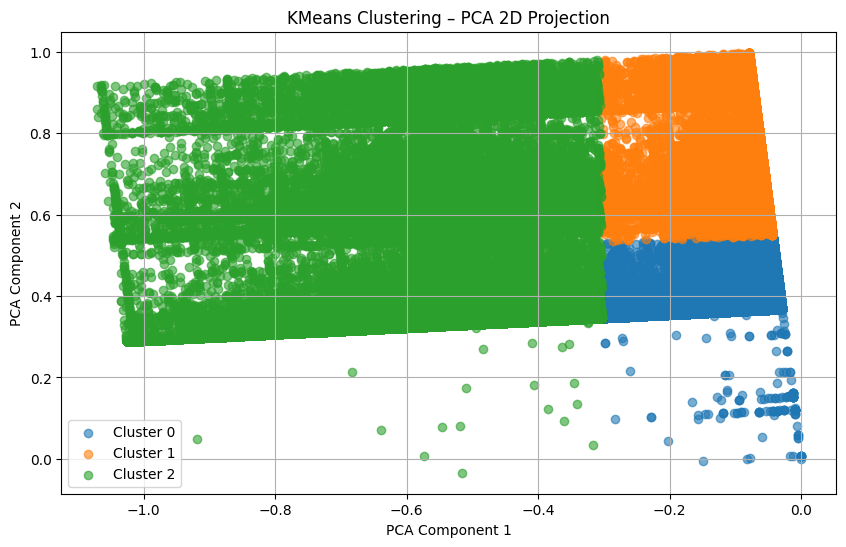

In [ ]:
# Option 1: PCA Visualization of KMeans Clusters

from pyspark.ml.feature import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Run PCA to reduce features to 2D
pca = PCA(k=2, inputCol="feature", outputCol="pcaFeatures")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# Step 2: Add predictions from KMeans
df_kmeans_pca = best_model.transform(df_pca)

# Step 3: Convert to Pandas for plotting
df_pd = df_kmeans_pca.select("pcaFeatures", "prediction").toPandas()
df_pd["x"] = df_pd["pcaFeatures"].apply(lambda vec: float(vec[0]))
df_pd["y"] = df_pd["pcaFeatures"].apply(lambda vec: float(vec[1]))

# Step 4: Plot clusters in 2D
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_pd["prediction"].unique()):
    subset = df_pd[df_pd["prediction"] == cluster_id]
    plt.scatter(subset["x"], subset["y"], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("KMeans Clustering – PCA 2D Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


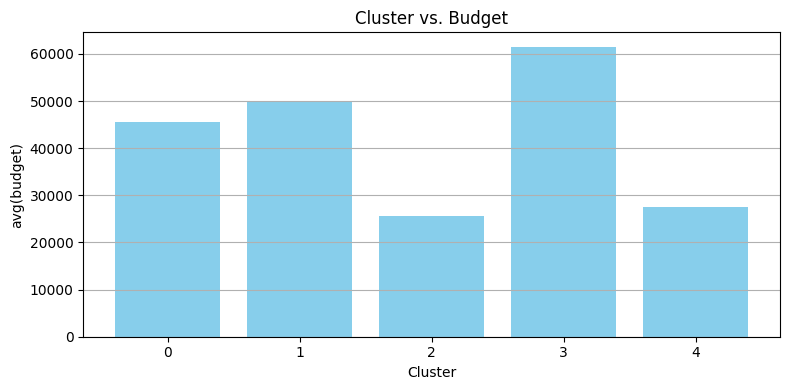

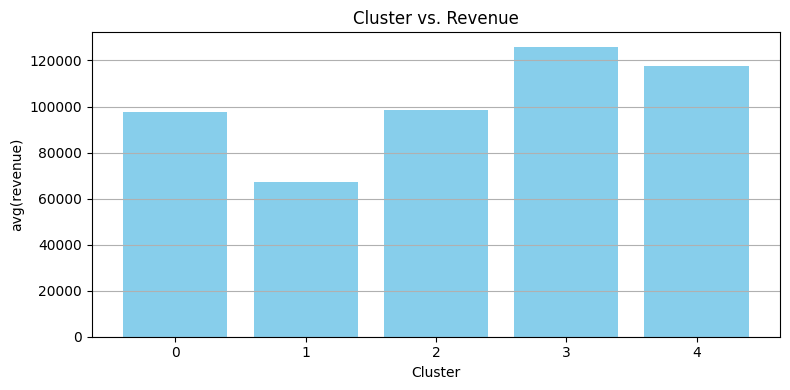

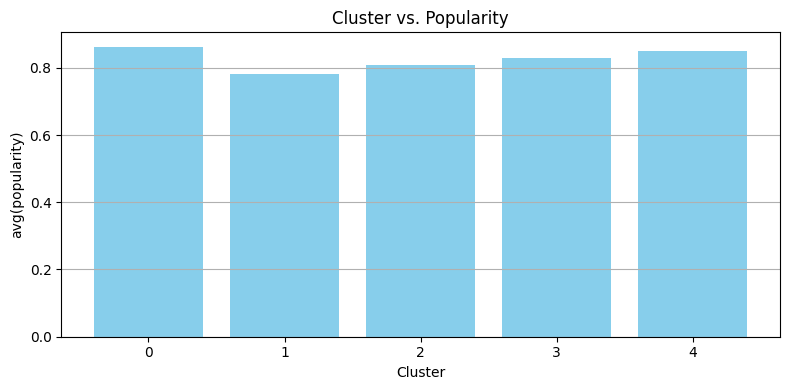

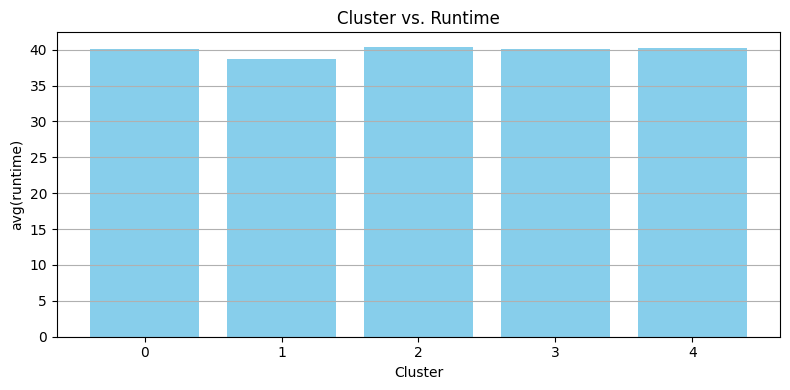

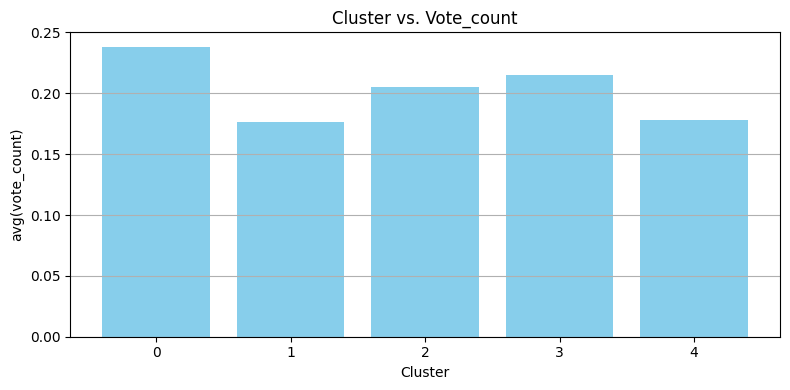

In [ ]:
# Bar Charts – Cluster vs. Budget, Revenue, Popularity, etc. (KMeans)
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F

# Step 1: Re-read and prepare original data
df_raw = spark.read.csv("/content/drive/MyDrive/machine/TMDB_movie_dataset_v11.csv", header=True, inferSchema=True)
cols_to_cast = ["budget", "popularity", "runtime", "vote_average", "vote_count", "revenue"]
for col_name in cols_to_cast:
    df_raw = df_raw.withColumn(col_name, col(col_name).cast(FloatType()))
df_raw = df_raw.select(*cols_to_cast)

# Step 2: Join KMeans predictions to original data using row ID
df_kmeans_profile = df_kmeans.select("prediction").withColumn("row_id", F.monotonically_increasing_id()) \
    .join(df_raw.withColumn("row_id", F.monotonically_increasing_id()), on="row_id") \
    .drop("row_id")

# Step 3: Convert cluster averages to Pandas
df_avg = df_kmeans_profile.groupBy("prediction").avg(*cols_to_cast).orderBy("prediction").toPandas()

# Step 4: Plot bar charts for each feature
features_to_plot = ["avg(budget)", "avg(revenue)", "avg(popularity)", "avg(runtime)", "avg(vote_count)"]

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    plt.bar(df_avg["prediction"], df_avg[feature], color="skyblue")
    plt.title(f"Cluster vs. {feature.replace('avg(', '').replace(')', '').capitalize()}")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.grid(axis='y')
    plt.xticks(df_avg["prediction"])
    plt.tight_layout()
    plt.show()


---
# **Task 5**
---

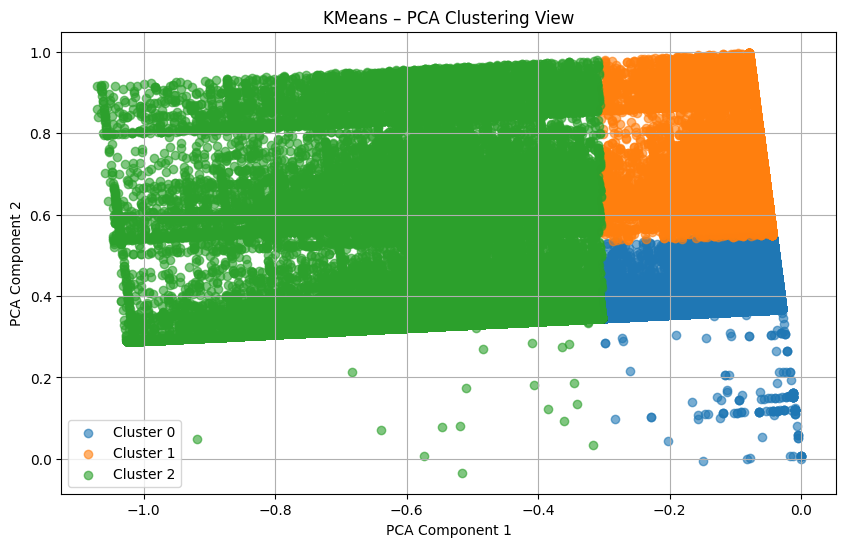

In [ ]:
# PCA Visualization (2D Plot) for KMeans
from pyspark.ml.feature import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Run PCA on scaled features
pca = PCA(k=2, inputCol="feature", outputCol="pcaFeatures")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)
df_kmeans_pca = best_model.transform(df_pca)

# Convert to Pandas
df_pd = df_kmeans_pca.select("pcaFeatures", "prediction").toPandas()
df_pd["x"] = df_pd["pcaFeatures"].apply(lambda vec: float(vec[0]))
df_pd["y"] = df_pd["pcaFeatures"].apply(lambda vec: float(vec[1]))

# Plot
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_pd["prediction"].unique()):
    subset = df_pd[df_pd["prediction"] == cluster_id]
    plt.scatter(subset["x"], subset["y"], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("KMeans – PCA Clustering View")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


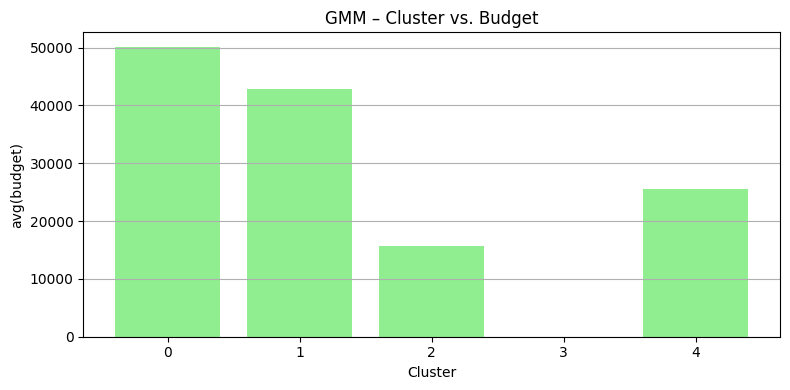

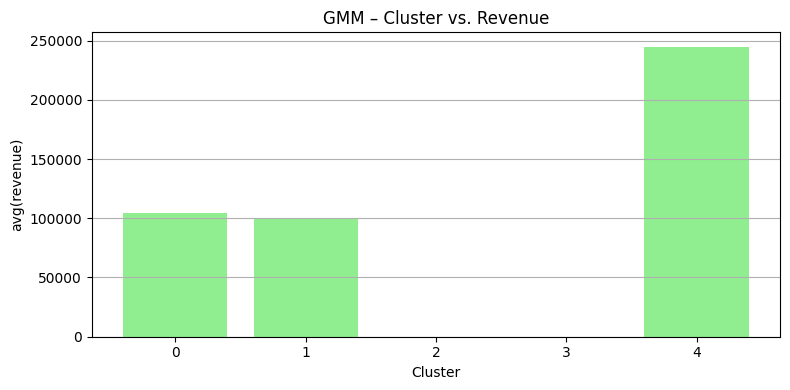

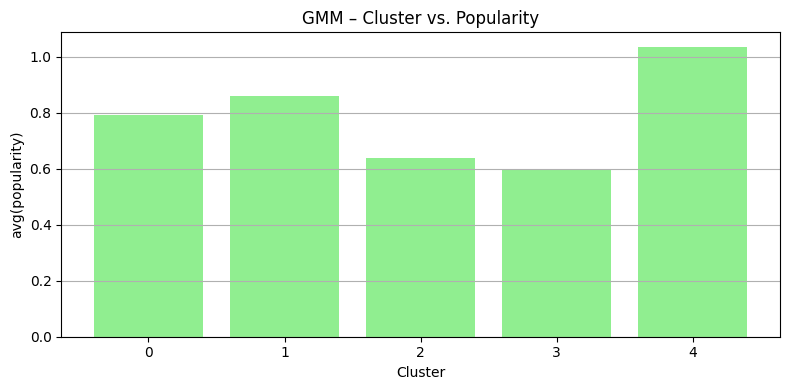

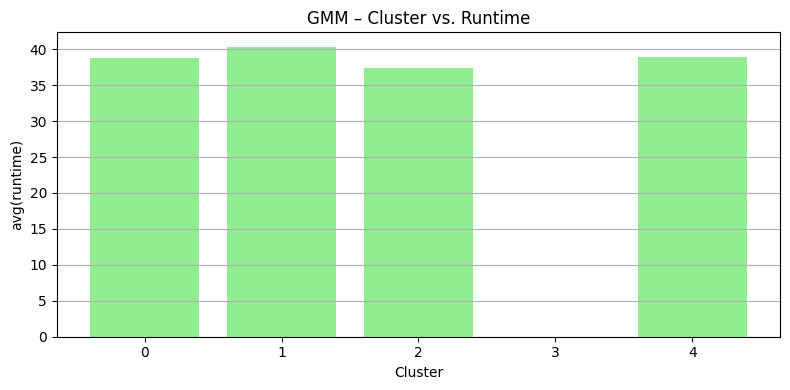

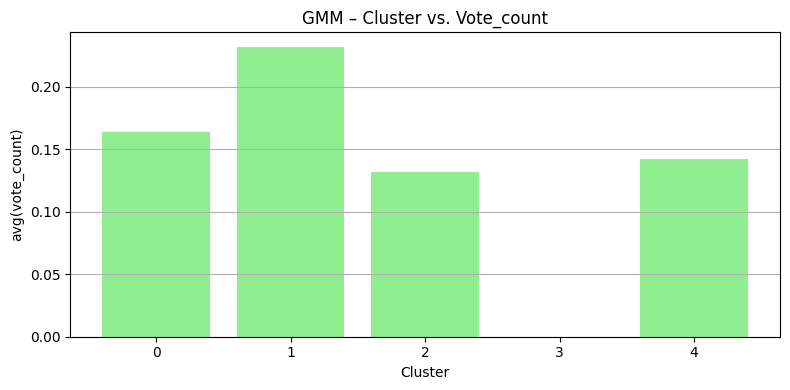

In [ ]:
# Bar chart visualization of cluster profiles for GMM
import matplotlib.pyplot as plt

# df_gmm_profile must already be joined with df_raw and contain predictions
df_avg_gmm = df_gmm_profile.groupBy("prediction").avg(
    "budget", "revenue", "popularity", "runtime", "vote_count"
).orderBy("prediction").toPandas()

features_to_plot = ["avg(budget)", "avg(revenue)", "avg(popularity)", "avg(runtime)", "avg(vote_count)"]

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    plt.bar(df_avg_gmm["prediction"], df_avg_gmm[feature], color="lightgreen")
    plt.title(f"GMM – Cluster vs. {feature.replace('avg(', '').replace(')', '').capitalize()}")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.grid(axis='y')
    plt.xticks(df_avg_gmm["prediction"])
    plt.tight_layout()
    plt.show()


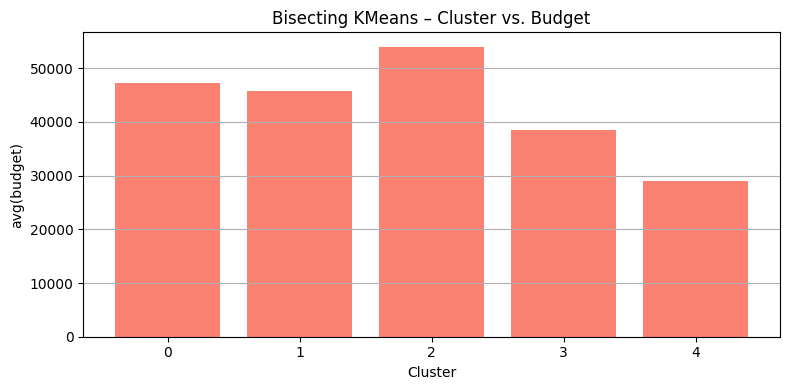

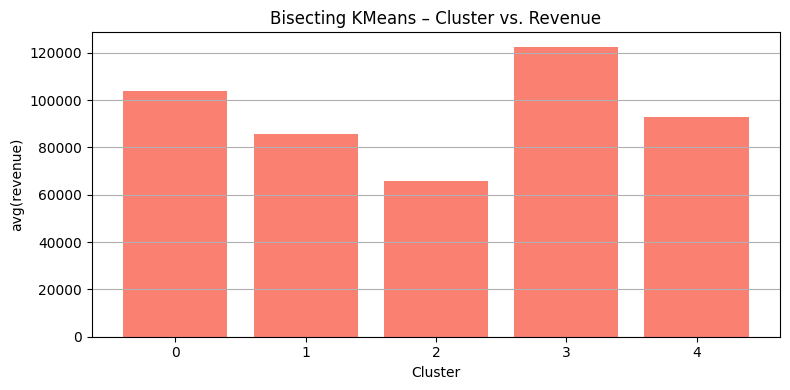

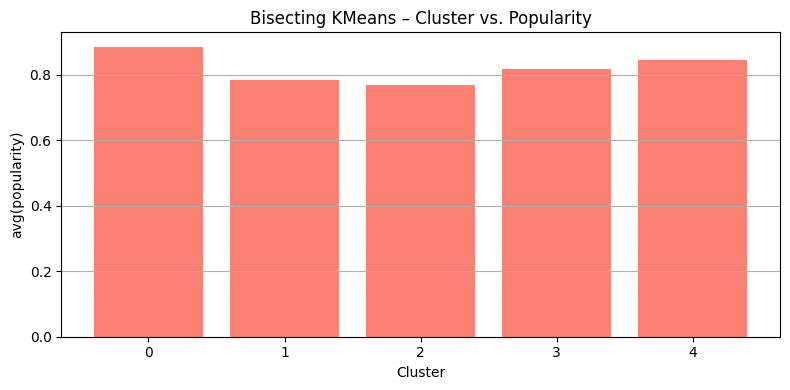

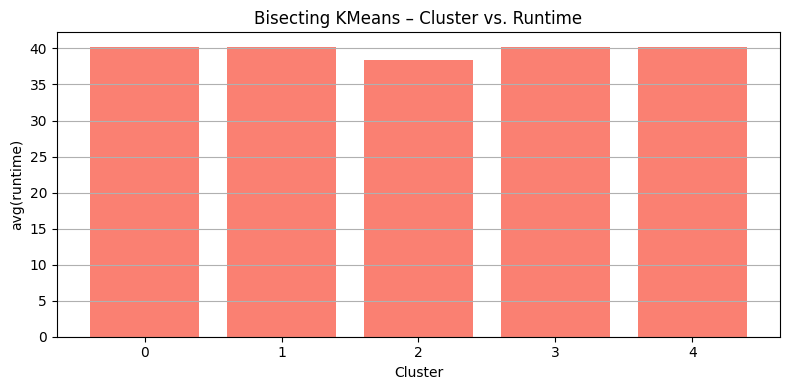

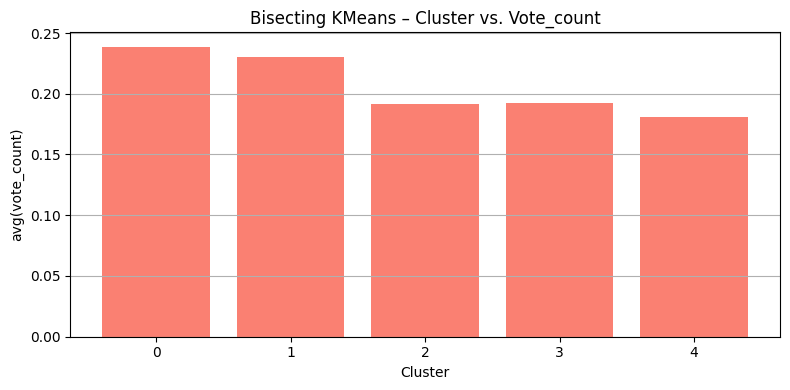

In [ ]:
# Bar chart visualization of cluster profiles for Bisecting KMeans
import matplotlib.pyplot as plt

# df_bkm_profile must already be joined with df_raw and contain predictions
df_avg_bkm = df_bkm_profile.groupBy("prediction").avg(
    "budget", "revenue", "popularity", "runtime", "vote_count"
).orderBy("prediction").toPandas()

features_to_plot = ["avg(budget)", "avg(revenue)", "avg(popularity)", "avg(runtime)", "avg(vote_count)"]

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    plt.bar(df_avg_bkm["prediction"], df_avg_bkm[feature], color="salmon")
    plt.title(f"Bisecting KMeans – Cluster vs. {feature.replace('avg(', '').replace(')', '').capitalize()}")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.grid(axis='y')
    plt.xticks(df_avg_bkm["prediction"])
    plt.tight_layout()
    plt.show()


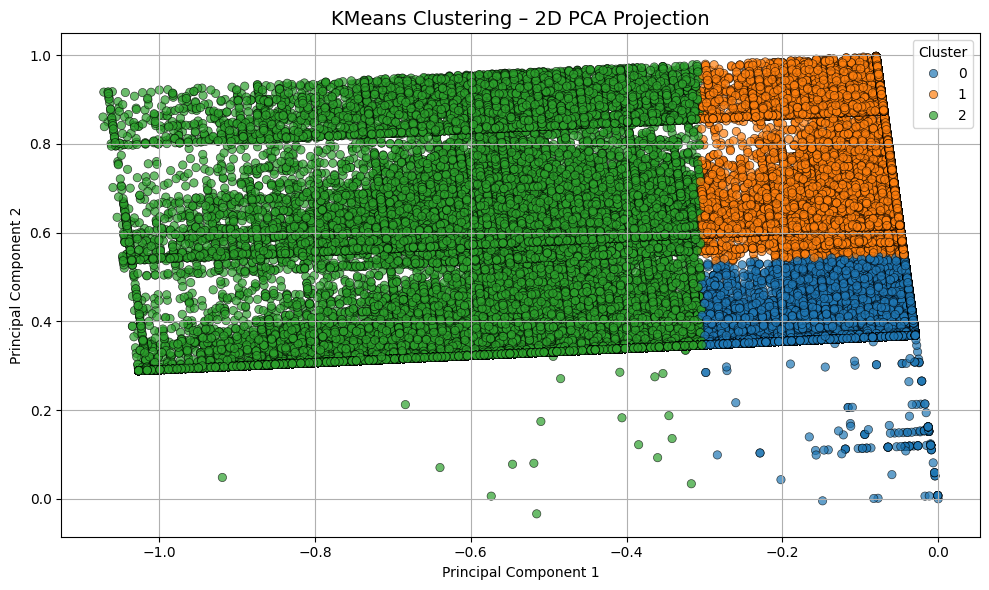

In [ ]:
# Advanced PCA Plot with KMeans Cluster Labels
from pyspark.ml.feature import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Run PCA
pca = PCA(k=2, inputCol="feature", outputCol="pcaFeatures")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)
df_kmeans_pca = best_model.transform(df_pca)

# Convert to Pandas
pdf = df_kmeans_pca.select("pcaFeatures", "prediction").toPandas()
pdf["x"] = pdf["pcaFeatures"].apply(lambda v: float(v[0]))
pdf["y"] = pdf["pcaFeatures"].apply(lambda v: float(v[1]))

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdf, x="x", y="y", hue="prediction", palette="tab10", alpha=0.7, edgecolor='k')
plt.title("KMeans Clustering – 2D PCA Projection", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


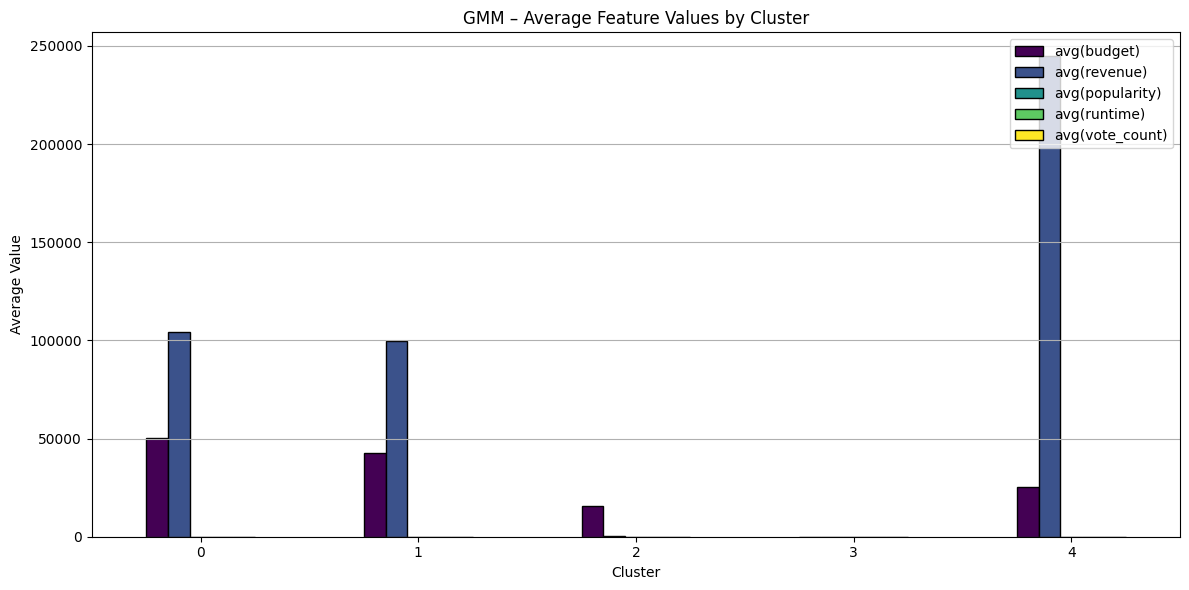

In [ ]:
# GMM Cluster Profile Comparison with grouped bar plot
import matplotlib.pyplot as plt

# Convert to pandas
gmm_avg = df_gmm_profile.groupBy("prediction").avg(
    "budget", "revenue", "popularity", "runtime", "vote_count"
).orderBy("prediction").toPandas()

# Plot grouped bars
features = ["avg(budget)", "avg(revenue)", "avg(popularity)", "avg(runtime)", "avg(vote_count)"]
gmm_avg.set_index("prediction", inplace=True)
gmm_avg[features].plot(kind='bar', figsize=(12, 6), colormap="viridis", edgecolor="black")

plt.title("GMM – Average Feature Values by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()


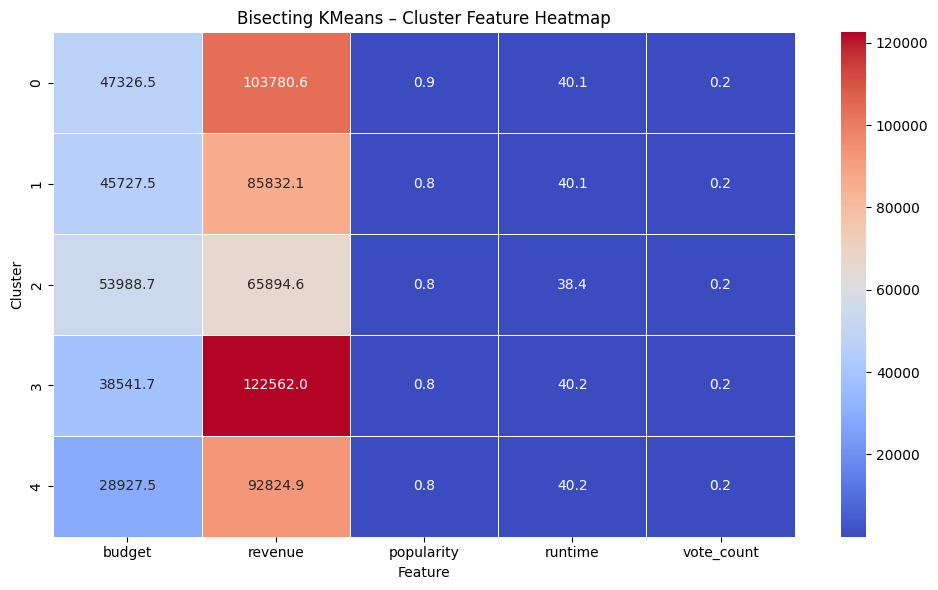

In [ ]:
# Heatmap to visualize how features differ per cluster
import seaborn as sns
import matplotlib.pyplot as plt

# Get average per cluster
bkm_avg = df_bkm_profile.groupBy("prediction").avg(
    "budget", "revenue", "popularity", "runtime", "vote_count"
).orderBy("prediction").toPandas()

# Rename and clean
bkm_avg = bkm_avg.rename(columns=lambda x: x.replace("avg(", "").replace(")", ""))
bkm_avg.set_index("prediction", inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(bkm_avg, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".1f")
plt.title("Bisecting KMeans – Cluster Feature Heatmap")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


**
 Legal Consideration**


While working with the TMDB movie dataset, I made sure to look into the legal aspects of data usage. The dataset was sourced from Kaggle and is based on TMDB, which is openly available for research and educational purposes. However, I understand that in a real-world or commercial setting, we would need to double-check licensing and terms of reuse, especially if the data was coming from APIs or other platforms. It’s important to ensure compliance with copyright laws and terms of service so that our work is legally safe and doesn’t infringe on intellectual property rights.





** Social Consideration**
From a social point of view, I thought about how using clustering can affect how people see movies. For example, if our clusters were used in a movie recommendation engine or content tagging system, there's a chance it could unintentionally reinforce biases — like giving more importance to high-budget or mainstream films while ignoring indie or culturally specific content. That’s why it’s important to be socially aware when designing and interpreting models, and to avoid building systems that could marginalize certain types of content or communities.



** Ethical Consideration**


On the ethical side, I was careful to ensure that none of the data used included anything personal or sensitive. Our features were all numeric and movie-based (like budget, revenue, etc.), which means we avoided any direct ethical violations. But beyond that, I tried to think ethically when interpreting clusters. For instance, just because one cluster had low revenue doesn’t mean those movies are “bad” — they might be independent or experimental. So I was cautious not to make biased or unfair judgments based on the data. Ethical modeling is about fairness, respect, and not jumping to conclusions.

